In [17]:
# Define font properties for general text
font_properties = {'family': 'DejaVu Sans', 'size': 12}

# Define font properties for titles
font_properties_titles = {'family': 'DejaVu Sans', 'size': 20}

# Define font properties for axes labels
font_properties_axes = {'family': 'DejaVu Sans', 'size': 16}


C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\4052971631.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\4052971631.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
C:\Users\RaymondCarpenter\AppData\Local\Temp\ipykernel_29940\4052971631.py:27: SettingWithCopyWarning: 
A value is try

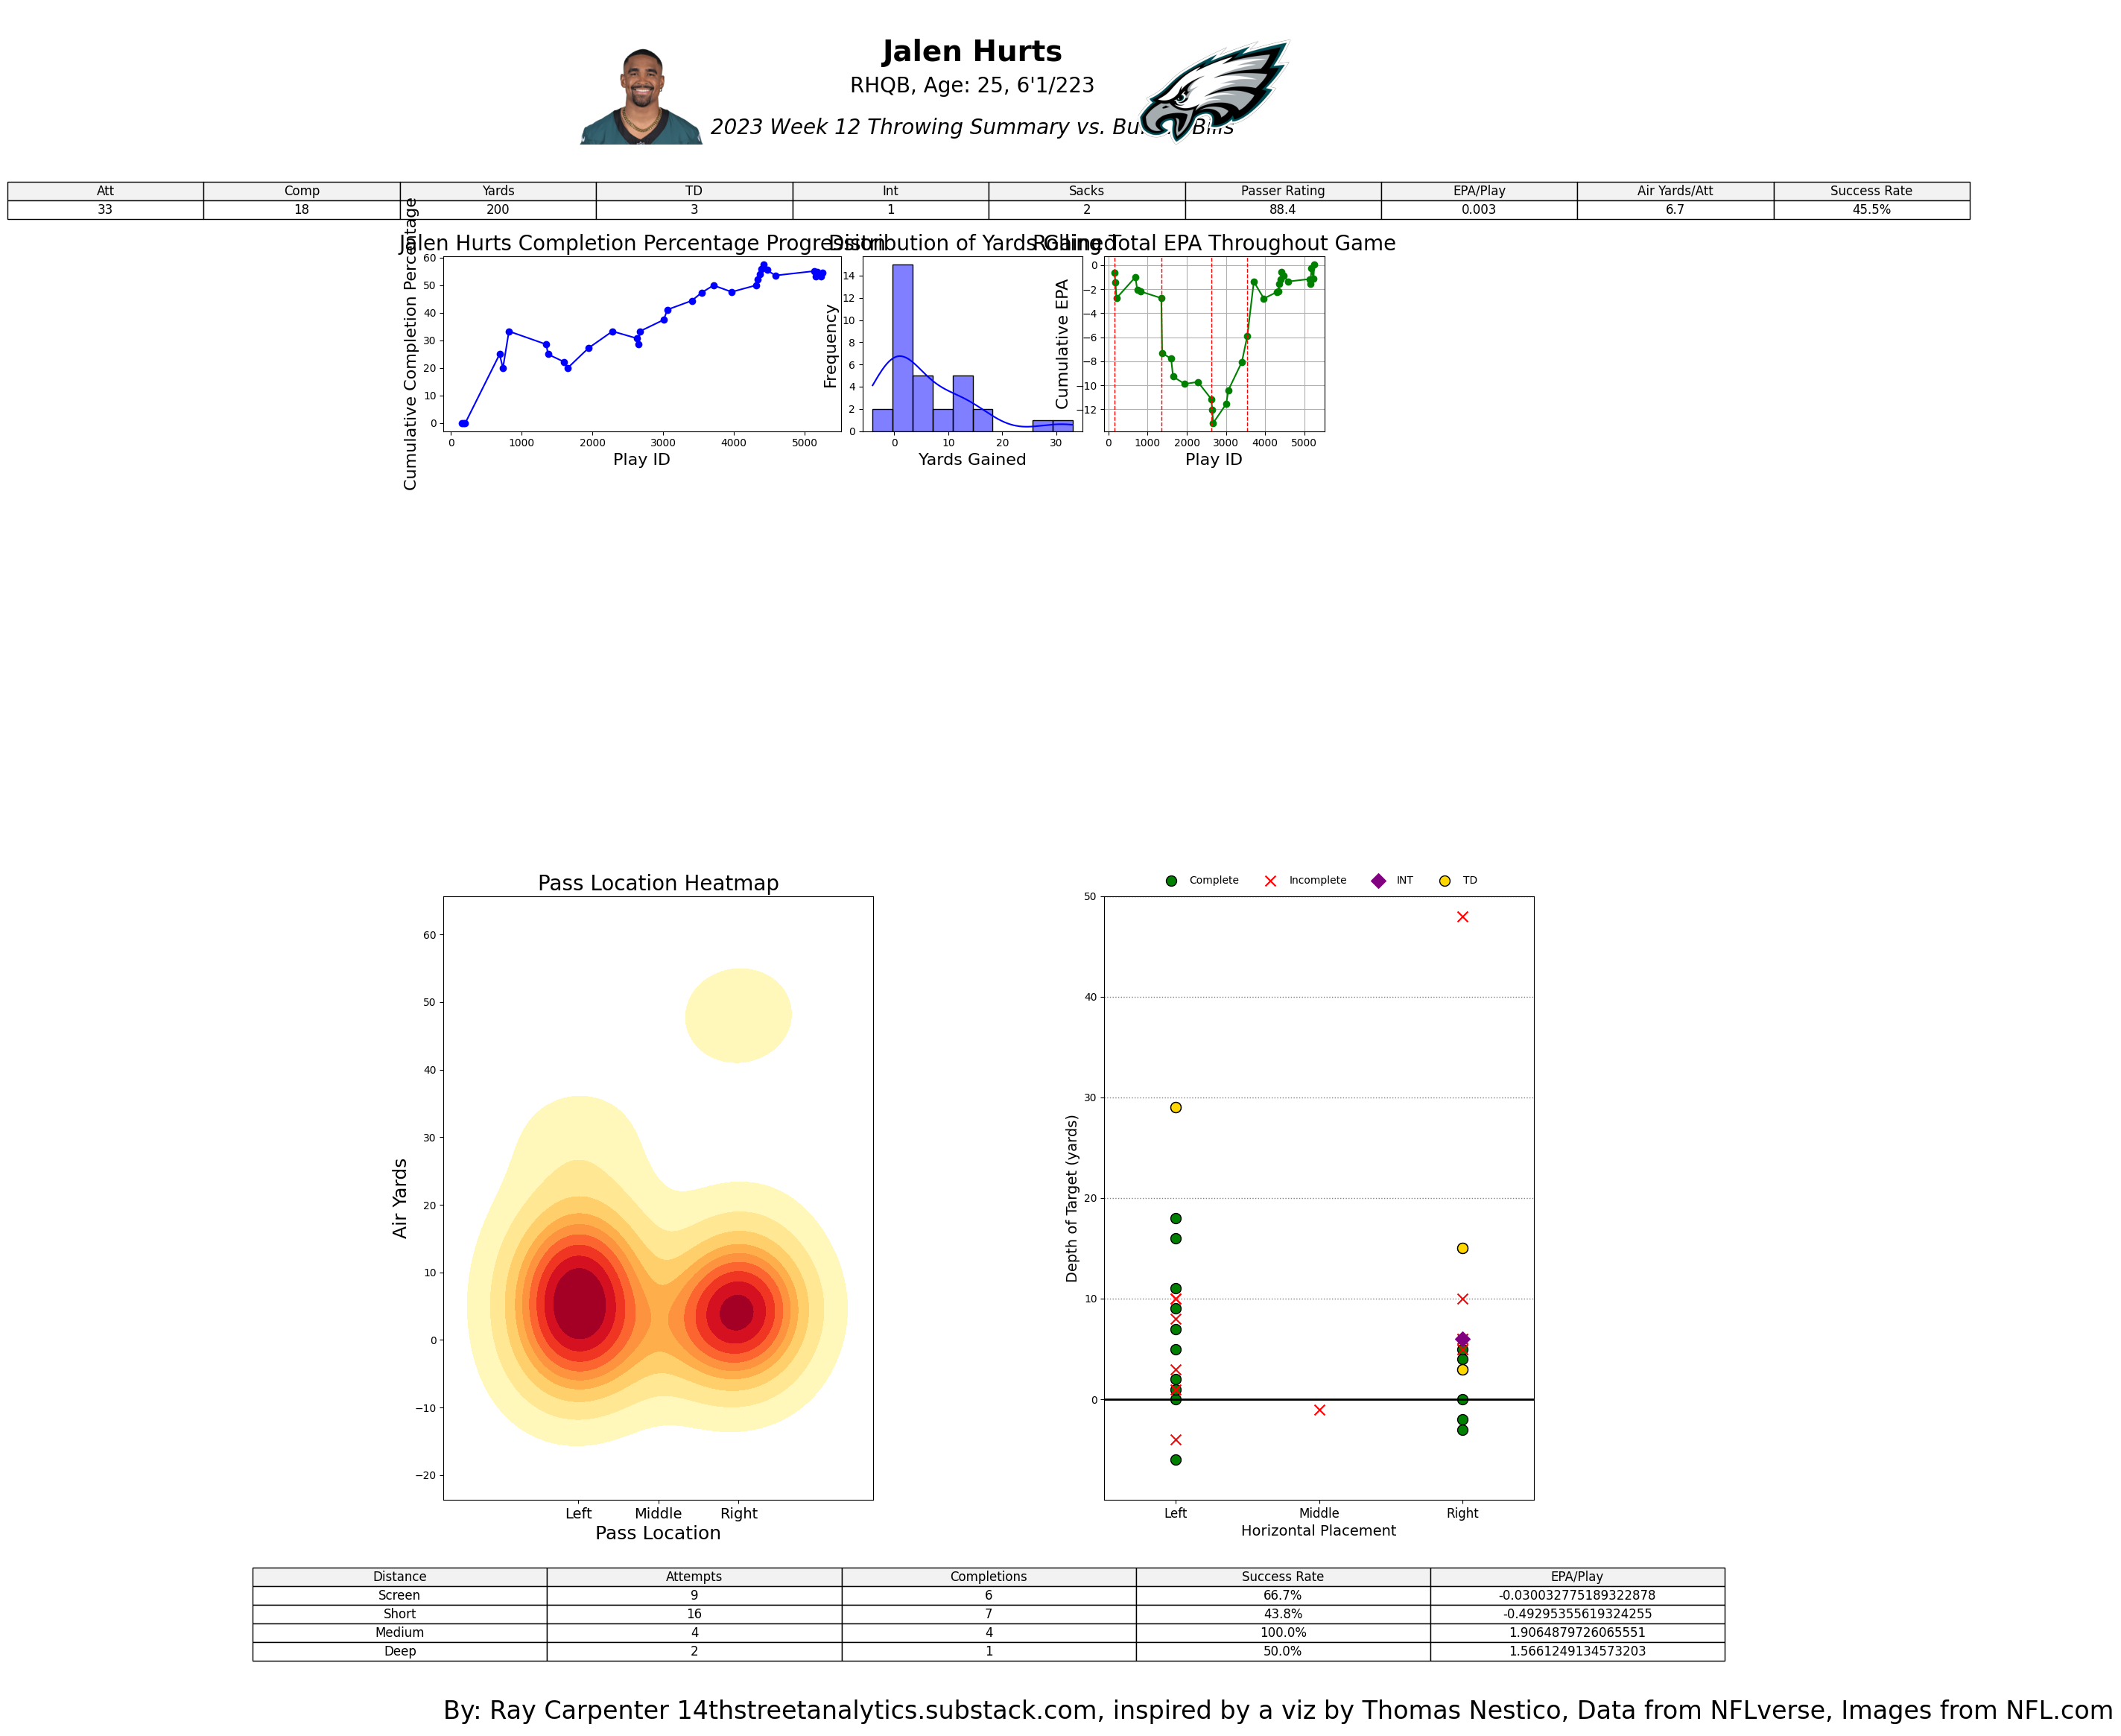

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Additional metrics calculations
game_data['epa_per_play'] = game_data['epa']
epa_per_play = round(game_data['epa_per_play'].mean(), 3)  # Show 3 decimal places

air_yards_per_attempt = round(game_data['air_yards'].sum() / game_data['pass_attempt'].sum(), 2)
success_rate = round(game_data[game_data['epa'] > 0].shape[0] / game_data.shape[0] * 100, 1)

# Calculate passer rating
completions = game_data['complete_pass'].sum()
attempts = game_data['pass_attempt'].sum()
yards = game_data['passing_yards'].sum()
touchdowns = game_data['pass_touchdown'].sum()
interceptions = game_data['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Calculate rolling total EPA
game_data['rolling_total_epa'] = game_data['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data[game_data['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data['pass_distance_category'] = pd.cut(game_data['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean'
}).reset_index()

pass_distance_summary['Success Rate'] = (pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']) * 100
pass_distance_summary['EPA/Play'] = pass_distance_summary['epa']
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]
pass_distance_summary.columns = ['Distance', 'Attempts', 'Completions', 'Success Rate', 'EPA/Play']

# Format numbers without decimal points in the tables
pass_distance_summary['Attempts'] = pass_distance_summary['Attempts'].astype(int)
pass_distance_summary['Completions'] = pass_distance_summary['Completions'].astype(int)
pass_distance_summary['Success Rate'] = pass_distance_summary['Success Rate'].apply(lambda x: f"{x:.1f}%")

# Summary Table
summary_table = {
    'Att': [int(game_data['pass_attempt'].sum())],
    'Comp': [int(game_data['complete_pass'].sum())],
    'Yards': [int(game_data['passing_yards'].sum())],
    'TD': [int(game_data['pass_touchdown'].sum())],
    'Int': [int(game_data['interception'].sum())],
    'Sacks': [int(game_data['sack'].sum())],
    'Passer Rating': [passer_rating],
    'EPA/Play': [epa_per_play],
    'Air Yards/Att': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\hurts_headshot.png'
logo_path = r'C:\Users\RaymondCarpenter\Documents\GitHub\14thstreetanalytics\throwing_summary\philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)

# Function to create the Jalen Hurts dashboard
def jalen_hurts_dashboard(game_data: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, pass_distance_summary: pd.DataFrame, quarter_positions):
    # Create a 20 by 30 figure to make it taller
    fig = plt.figure(figsize=(20, 30))

    # Create a gridspec layout with more space for key graphs
  # Adjusted the ratios for main plots
    gs = gridspec.GridSpec(14, 9,  # Keep the same number of rows and columns
                       height_ratios=[2, 18, 12, 30, 30, 30, 1, 1, 50, 50, 10, 5, 5, 5],  # Increase ratios for key plots
                       width_ratios=[1, 18, 18, 1, 18, 1, 18, 18, 1])

# Define the positions of each subplot in the grid with adjusted sizes
    ax_headshot = fig.add_subplot(gs[1, 1:3])
    ax_bio = fig.add_subplot(gs[1, 3:5])
    ax_logo = fig.add_subplot(gs[1, 5:7])

    ax_summary_table = fig.add_subplot(gs[2, 1:8])  # Top summary table

# Increased space for the top three plots by adjusting grid size
    ax_completion_plot = fig.add_subplot(gs[3, 1:3])
    ax_yards_dist = fig.add_subplot(gs[3, 3:5])
    ax_rolling_epa = fig.add_subplot(gs[3, 5:7])

# Adjusting the layout to place the heat map and pass chart next to each other with increased space
    ax_pass_heatmap = fig.add_subplot(gs[8:10, 1:4])  # Left side for pass location heat map
    ax_passing_chart = fig.add_subplot(gs[8:10, 5:8])  # Right side for pass location chart

    ax_pass_distance = fig.add_subplot(gs[-3, 1:8])  # Bottom pass distance table

    ax_footer = fig.add_subplot(gs[-1, 1:8])  # Footer below the bottom table
    ax_header = fig.add_subplot(gs[0, 1:8]) 
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])


    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information
    ax_bio.text(0.5, 0.8, 'Jalen Hurts', fontsize=28, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.5, 'RHQB, Age: 25, 6\'1/223', fontsize=20, ha='center')
    ax_bio.text(0.5, 0.1, '2023 Week 12 Throwing Summary vs. Buffalo Bills', fontsize=20, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    # Summary Table Plot
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.12] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    # Completion Percentage Progression Plot
    ax_completion_plot.plot(game_data['play_id'], game_data['cumulative_completion_percentage'], marker='o', linestyle='-', color='blue')
    ax_completion_plot.set_xlabel('Play ID', fontdict={'size': 16})
    ax_completion_plot.set_ylabel('Cumulative Completion Percentage', fontdict={'size': 16})
    ax_completion_plot.set_title('Jalen Hurts Completion Percentage Progression', fontdict={'size': 20})

    # Yards Gained Distribution Plot
    sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 16})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 16})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 20})

    # Rolling Total EPA Plot
    ax_rolling_epa.plot(game_data['play_id'], game_data['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 16})
    ax_rolling_epa.set_ylabel('Cumulative EPA', fontdict={'size': 16})
    ax_rolling_epa.set_title('Rolling Total EPA Throughout Game', fontdict={'size': 20})
    ax_rolling_epa.grid(True)

    # Pass Location Heat Map
    sns.kdeplot(
        x=game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1}), 
        y=game_data['air_yards'], cmap='YlOrRd', shade=True, ax=ax_pass_heatmap, cbar=False
    )
    ax_pass_heatmap.set_xlabel('Pass Location', fontdict={'size': 18})
    ax_pass_heatmap.set_ylabel('Air Yards', fontdict={'size': 18})
    ax_pass_heatmap.set_title('Pass Location Heatmap', fontdict={'size': 20})
    ax_pass_heatmap.set_xticks([-1, 0, 1])
    ax_pass_heatmap.set_xticklabels(['Left', 'Middle', 'Right'], fontdict={'size': 14})

    # Pass Location Chart Plot
    game_data['x'] = game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
    game_data['y'] = game_data['air_yards']

    complete = game_data[game_data['complete_pass'] == 1]
    incomplete = game_data[game_data['complete_pass'] == 0]
    interceptions = game_data[game_data['interception'] == 1]
    touchdowns = game_data[game_data['pass_touchdown'] == 1]

    ax_passing_chart.scatter(complete['x'], complete['y'], color='green', label='Complete', s=100, edgecolor='black')
    ax_passing_chart.scatter(incomplete['x'], incomplete['y'], color='red', marker='x', label='Incomplete', s=100)
    ax_passing_chart.scatter(interceptions['x'], interceptions['y'], color='purple', marker='D', label='INT', s=100)
    ax_passing_chart.scatter(touchdowns['x'], touchdowns['y'], color='gold', marker='o', label='TD', s=100, edgecolor='black')

    # Add horizontal dotted lines every 10 yards
    for y in range(0, 51, 10):
        ax_passing_chart.axhline(y, color='gray', linestyle=':', linewidth=1)

    # Formatting
    ax_passing_chart.axhline(0, color='black', linewidth=2)  # Line of scrimmage
    ax_passing_chart.set_xlim(-1.5, 1.5)
    ax_passing_chart.set_ylim(-10, 50)
    ax_passing_chart.set_xticks([-1, 0, 1])
    ax_passing_chart.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_passing_chart.set_yticks(range(0, 51, 10))
    ax_passing_chart.set_xlabel('Horizontal Placement', fontsize=14)
    ax_passing_chart.set_ylabel('Depth of Target (yards)', fontsize=14)
    
    # Set legend as the title, placed on top
    ax_passing_chart.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=10, frameon=False)

    # Pass Distance Table
    ax_pass_distance.axis('off')
    pass_distance_table = ax_pass_distance.table(cellText=pass_distance_summary.values,
                                                 colLabels=pass_distance_summary.columns,
                                                 cellLoc='center',
                                                 loc='center',
                                                 colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
                                                 colWidths=[0.18] * len(pass_distance_summary.columns))
    pass_distance_table.auto_set_font_size(False)
    pass_distance_table.set_fontsize(12)
    pass_distance_table.scale(1.5, 1.5)

    # Footer
    ax_footer.text(0, 1, 'By: Ray Carpenter 14thstreetanalytics.substack.com, inspired by a viz by Thomas Nestico, Data from NFLverse, Images from NFL.com', ha='left', va='top', fontsize=24)

    # Adjust the spacing between subplots with increased padding
    plt.tight_layout(pad=1.0)  # Reduce padding to bring elements closer together

    # Show the figure
    plt.show()

# Call the dashboard function
jalen_hurts_dashboard(game_data, headshot, logo, summary_df, pass_distance_summary, quarter_positions)


/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/2434104707.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data_passing['cumulative_completions'] = game_data_passing['complete_pass'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/2434104707.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data_passing['cumulative_attempts'] = game_data_passing['pass_attempt'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/2434104707.py:31

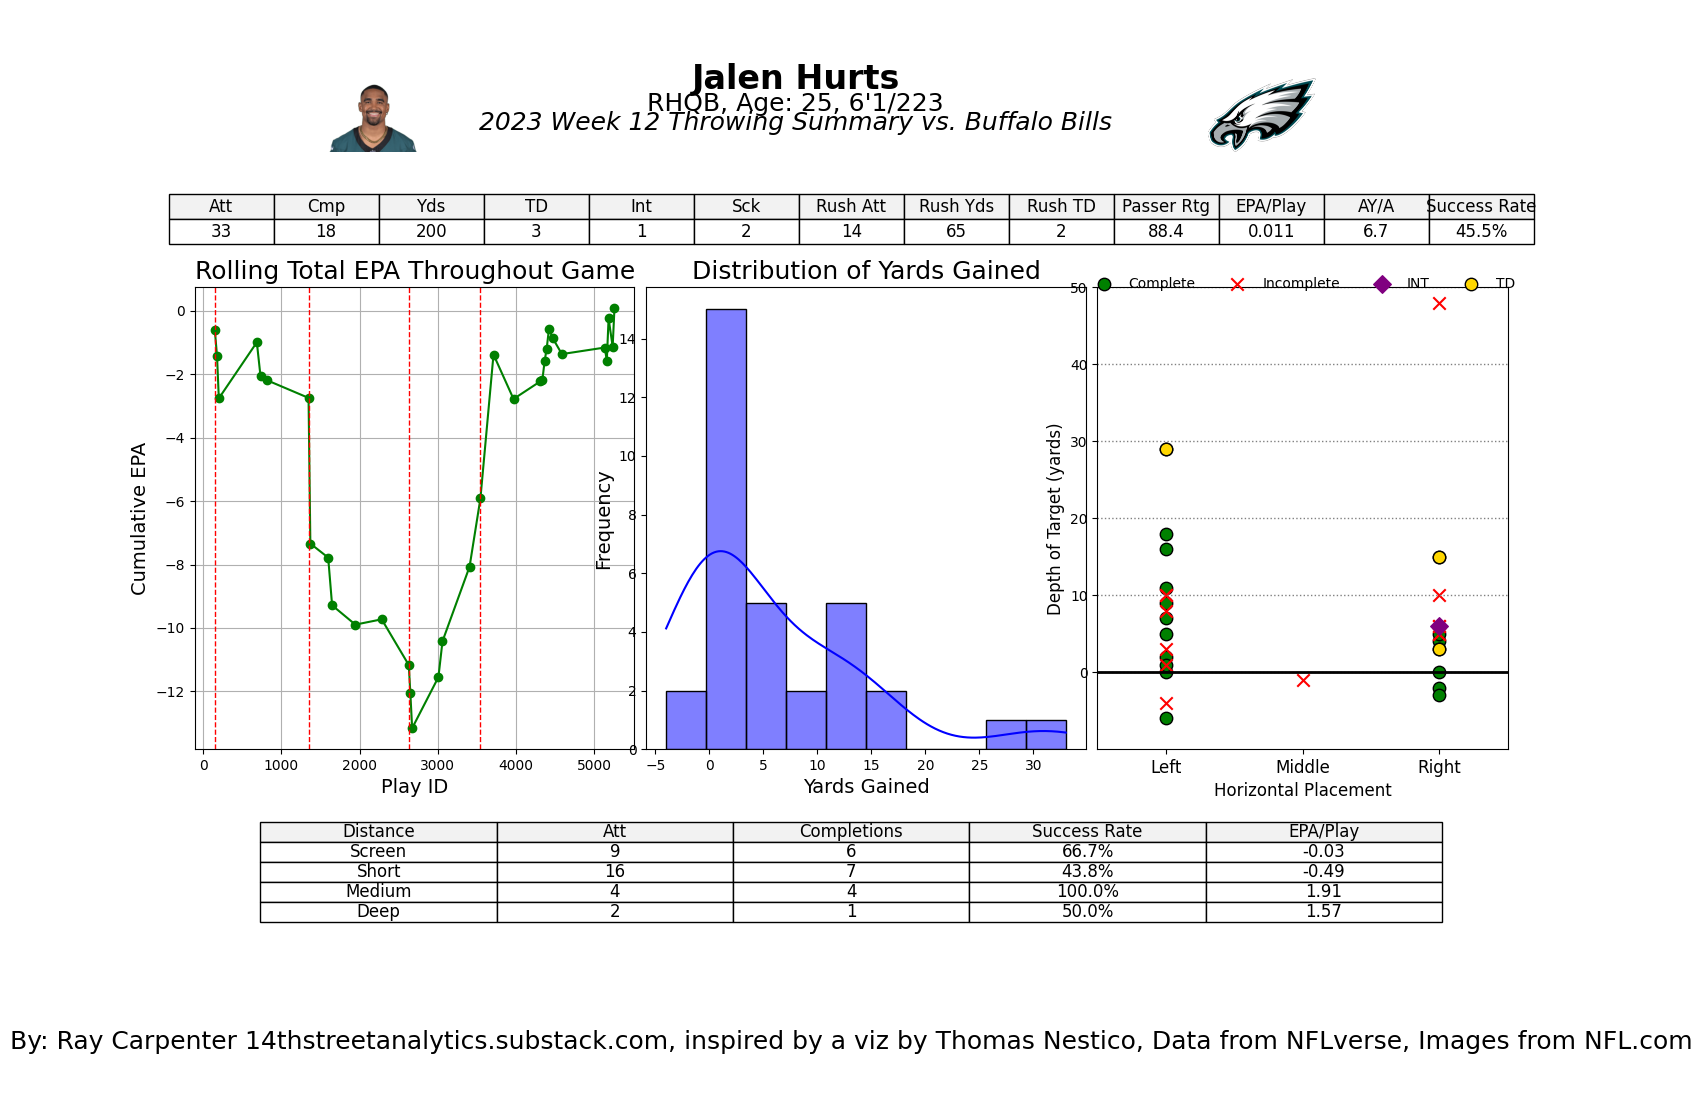

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]

# Separate filters for passing and rushing plays
passing_plays = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']
rushing_plays = filtered_df[filtered_df['rusher_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data_passing = passing_plays[passing_plays['game_id'] == '2023_12_BUF_PHI']
game_data_rushing = rushing_plays[rushing_plays['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts for passing plays
game_data_passing['cumulative_completions'] = game_data_passing['complete_pass'].cumsum()
game_data_passing['cumulative_attempts'] = game_data_passing['pass_attempt'].cumsum()
game_data_passing['cumulative_completion_percentage'] = (
    game_data_passing['cumulative_completions'] / game_data_passing['cumulative_attempts']
) * 100

# Sum EPA for both passing and rushing plays
total_passing_epa = game_data_passing['epa'].sum()
total_rushing_epa = game_data_rushing['epa'].sum()
total_epa = total_passing_epa + total_rushing_epa

# Sum the total number of plays (passing attempts + rushing attempts)
total_plays = game_data_passing['pass_attempt'].sum() + game_data_rushing['rush_attempt'].sum()

# Calculate EPA per play
epa_per_play = round(total_epa / total_plays, 3)

air_yards_per_attempt = round(
    game_data_passing['air_yards'].sum() / game_data_passing['pass_attempt'].sum(), 2
)
success_rate = round(
    game_data_passing[game_data_passing['epa'] > 0].shape[0] / game_data_passing.shape[0] * 100, 1
)

# Calculate passer rating
completions = game_data_passing['complete_pass'].sum()
attempts = game_data_passing['pass_attempt'].sum()
yards = game_data_passing['passing_yards'].sum()
touchdowns = game_data_passing['pass_touchdown'].sum()
interceptions = game_data_passing['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Calculate rolling total EPA for passing plays
game_data_passing['rolling_total_epa'] = game_data_passing['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data_passing[game_data_passing['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data_passing['pass_distance_category'] = pd.cut(game_data_passing['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data_passing.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'sum'  # Sum EPA for each category
}).reset_index()

# Calculate EPA per play for each category by dividing total EPA by total pass attempts
pass_distance_summary['EPA/Play'] = (pass_distance_summary['epa'] / pass_distance_summary['pass_attempt']).round(2)

pass_distance_summary['Success Rate'] = (pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']) * 100
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]

# Update the column names, including changing "Attempts" to "Att"
pass_distance_summary.columns = ['Distance', 'Att', 'Completions', 'Success Rate', 'EPA/Play']

# Format numbers without decimal points in the tables
pass_distance_summary['Att'] = pass_distance_summary['Att'].astype(int)
pass_distance_summary['Completions'] = pass_distance_summary['Completions'].astype(int)
pass_distance_summary['Success Rate'] = pass_distance_summary['Success Rate'].apply(lambda x: f"{x:.1f}%")

# Calculate rushing statistics for Jalen Hurts
rush_attempts = game_data_rushing['rush_attempt'].sum()
rush_yards = game_data_rushing['rushing_yards'].sum()
rush_touchdowns = game_data_rushing['rush_touchdown'].sum()

# Update the summary table with passing and rushing stats
summary_table = {
    'Att': [int(game_data_passing['pass_attempt'].sum())],
    'Cmp': [int(game_data_passing['complete_pass'].sum())],
    'Yds': [int(game_data_passing['passing_yards'].sum())],
    'TD': [int(game_data_passing['pass_touchdown'].sum())],
    'Int': [int(game_data_passing['interception'].sum())],
    'Sck': [int(game_data_passing['sack'].sum())],
    'Rush Att': [int(rush_attempts)],        # Added Rush Att
    'Rush Yds': [int(rush_yards)],           # Added Rush Yds
    'Rush TD': [int(rush_touchdowns)],       # Added Rush TD
    'Passer Rtg': [passer_rating],
    'EPA/Play': [epa_per_play],              # Corrected EPA/Play
    'AY/A': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}

# Create the updated summary DataFrame
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/hurts_headshot.png'
logo_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)

def jalen_hurts_dashboard(game_data_passing: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, pass_distance_summary: pd.DataFrame, quarter_positions):
    # Create a more compact figure
    fig = plt.figure(figsize=(18, 14))  # Adjust figure size for compactness

    # Create a gridspec layout with adjusted settings for alignment and spacing
    gs = gridspec.GridSpec(6, 20,  # Using 20 columns for better spacing
                           height_ratios=[2, 4, 4, 25, 10, 5],  # Adjusted height ratio for row 4 and others
                           width_ratios=[1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1])  # Equal width for plots and tables

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 2:4])  # Positioned headshot
    ax_bio = fig.add_subplot(gs[1, 5:13])  # Centered bio text more
    ax_logo = fig.add_subplot(gs[1, 14:16])  # Positioned logo

    ax_summary_table = fig.add_subplot(gs[2, 1:19])

    # Adjust plot positions for compactness
    ax_rolling_epa = fig.add_subplot(gs[3, 1:7])  # Rolling EPA
    ax_yards_dist = fig.add_subplot(gs[3, 7:13])  # Yards Distribution
    ax_passing_chart = fig.add_subplot(gs[3, 13:19])  # Pass Location Chart

    ax_pass_distance = fig.add_subplot(gs[4, 1:19])  # Pass Distance Table

    ax_footer = fig.add_subplot(gs[-1, 1:19])  # Footer
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, left, and right
    ax_footer.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo correctly
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information with adjusted horizontal and vertical space
    ax_bio.text(0.5, 0.85, 'Jalen Hurts', fontsize=24, ha='center', fontweight='bold')  # Centered and adjusted
    ax_bio.text(0.5, 0.55, 'RHQB, Age: 25, 6\'1/223', fontsize=18, ha='center')  # Adjusted vertical spacing
    ax_bio.text(0.5, 0.3, '2023 Week 12 Throwing Summary vs. Buffalo Bills', fontsize=18, ha='center', fontstyle='italic')  # Adjusted vertical spacing
    ax_bio.axis('off')

    # Summary Table Plot - Adjusted for more compact cells
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.1] * len(summary_df.columns))  # Reduced column width
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set a smaller font size for compactness
    table.scale(0.8, 1.5)  # Reduced scale for compactness

    # Rolling Total EPA Plot
    ax_rolling_epa.plot(game_data_passing['play_id'], game_data_passing['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 14})
    ax_rolling_epa.set_ylabel('Cumulative EPA', fontdict={'size': 14})
    ax_rolling_epa.set_title('Rolling Total EPA Throughout Game', fontdict={'size': 18})
    ax_rolling_epa.grid(True)

    # Yards Gained Distribution Plot
    sns.histplot(game_data_passing['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 14})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 14})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 18})

    # Pass Location Chart Plot
    game_data_passing['x'] = game_data_passing['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
    game_data_passing['y'] = game_data_passing['air_yards']

    complete = game_data_passing[game_data_passing['complete_pass'] == 1]
    incomplete = game_data_passing[game_data_passing['complete_pass'] == 0]
    interceptions = game_data_passing[game_data_passing['interception'] == 1]
    touchdowns = game_data_passing[game_data_passing['pass_touchdown'] == 1]

    ax_passing_chart.scatter(complete['x'], complete['y'], color='green', label='Complete', s=80, edgecolor='black')
    ax_passing_chart.scatter(incomplete['x'], incomplete['y'], color='red', marker='x', label='Incomplete', s=80)
    ax_passing_chart.scatter(interceptions['x'], interceptions['y'], color='purple', marker='D', label='INT', s=80)
    ax_passing_chart.scatter(touchdowns['x'], touchdowns['y'], color='gold', marker='o', label='TD', s=80, edgecolor='black')

    # Add horizontal dotted lines every 10 yards
    for y in range(0, 51, 10):
        ax_passing_chart.axhline(y, color='gray', linestyle=':', linewidth=1)

    # Formatting
    ax_passing_chart.axhline(0, color='black', linewidth=2)  # Line of scrimmage
    ax_passing_chart.set_xlim(-1.5, 1.5)
    ax_passing_chart.set_ylim(-10, 50)
    ax_passing_chart.set_xticks([-1, 0, 1])
    ax_passing_chart.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_passing_chart.set_yticks(range(0, 51, 10))
    ax_passing_chart.set_xlabel('Horizontal Placement', fontsize=12)
    ax_passing_chart.set_ylabel('Depth of Target (yards)', fontsize=12)

    # Set legend as the title, placed on top
    ax_passing_chart.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=10, frameon=False)

    # Pass Distance Table
    ax_pass_distance.axis('off')
    pass_distance_table = ax_pass_distance.table(cellText=pass_distance_summary.values,
                                                 colLabels=pass_distance_summary.columns,
                                                 cellLoc='center',
                                                 loc='center',
                                                 colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
                                                 colWidths=[0.18] * len(pass_distance_summary.columns))
    pass_distance_table.auto_set_font_size(False)
    pass_distance_table.set_fontsize(12)  # Smaller font size
    pass_distance_table.scale(1, 1.2)  # Smaller scale

    # Footer
    ax_footer.text(0.5, 0.5, 'By: Ray Carpenter 14thstreetanalytics.substack.com, inspired by a viz by Thomas Nestico, Data from NFLverse, Images from NFL.com', 
                   ha='center', va='center', fontsize=18)

    # Adjust the spacing between subplots with increased padding
    plt.tight_layout(pad=1.5)  # Reduced padding for less whitespace

    # Show the figure
    plt.show()

# Call the modified dashboard function
jalen_hurts_dashboard(game_data_passing, headshot, logo, summary_df, pass_distance_summary, quarter_positions)


/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/293628551.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/293628551.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/293628551.py:27: SettingWithCopyWarning: 
A value 

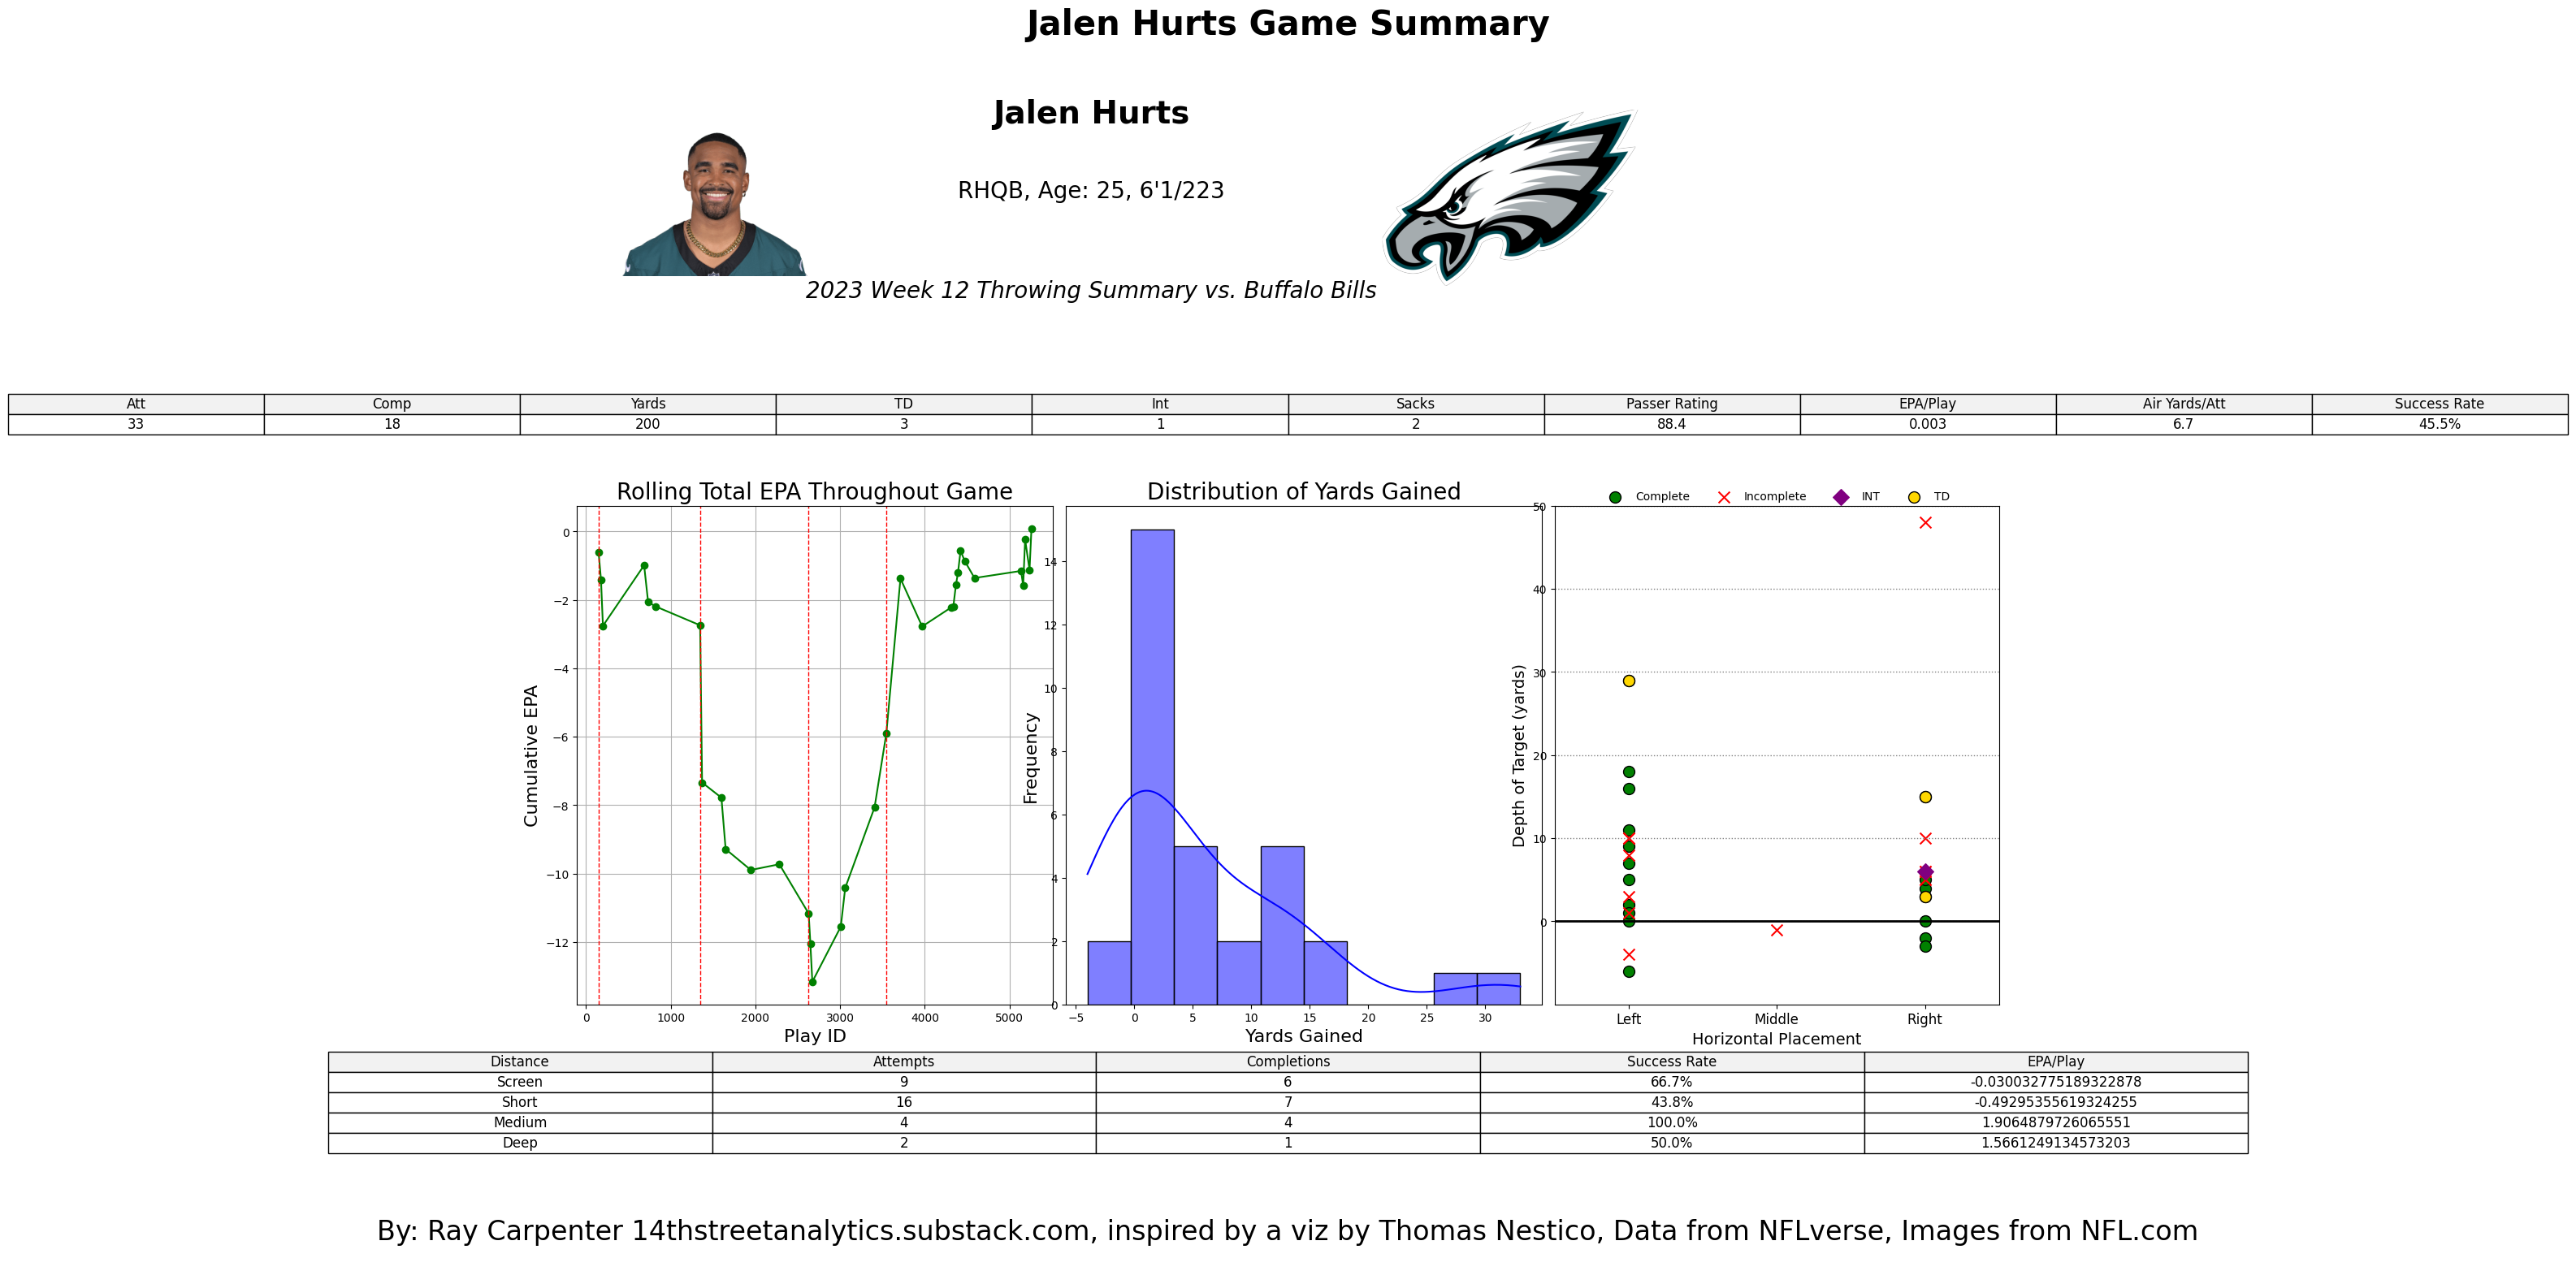

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Additional metrics calculations
game_data['epa_per_play'] = game_data['epa']
epa_per_play = round(game_data['epa_per_play'].mean(), 3)  # Show 3 decimal places

air_yards_per_attempt = round(game_data['air_yards'].sum() / game_data['pass_attempt'].sum(), 2)
success_rate = round(game_data[game_data['epa'] > 0].shape[0] / game_data.shape[0] * 100, 1)

# Calculate passer rating
completions = game_data['complete_pass'].sum()
attempts = game_data['pass_attempt'].sum()
yards = game_data['passing_yards'].sum()
touchdowns = game_data['pass_touchdown'].sum()
interceptions = game_data['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Calculate rolling total EPA
game_data['rolling_total_epa'] = game_data['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data[game_data['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data['pass_distance_category'] = pd.cut(game_data['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean'
}).reset_index()

pass_distance_summary['Success Rate'] = (pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']) * 100
pass_distance_summary['EPA/Play'] = pass_distance_summary['epa']
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]
pass_distance_summary.columns = ['Distance', 'Attempts', 'Completions', 'Success Rate', 'EPA/Play']

# Format numbers without decimal points in the tables
pass_distance_summary['Attempts'] = pass_distance_summary['Attempts'].astype(int)
pass_distance_summary['Completions'] = pass_distance_summary['Completions'].astype(int)
pass_distance_summary['Success Rate'] = pass_distance_summary['Success Rate'].apply(lambda x: f"{x:.1f}%")

# Summary Table
summary_table = {
    'Att': [int(game_data['pass_attempt'].sum())],
    'Comp': [int(game_data['complete_pass'].sum())],
    'Yards': [int(game_data['passing_yards'].sum())],
    'TD': [int(game_data['pass_touchdown'].sum())],
    'Int': [int(game_data['interception'].sum())],
    'Sacks': [int(game_data['sack'].sum())],
    'Passer Rating': [passer_rating],
    'EPA/Play': [epa_per_play],
    'Air Yards/Att': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/hurts_headshot.png'
logo_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)


def jalen_hurts_dashboard(game_data: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, pass_distance_summary: pd.DataFrame, quarter_positions):
    # Create a 24 by 20 figure for better control over spacing
    fig = plt.figure(figsize=(24, 20))

    # Create a gridspec layout with more columns for finer control
    gs = gridspec.GridSpec(6, 20,  # Using 20 columns for better spacing
                           height_ratios=[2, 20, 9, 40, 10, 5],  # Adjusted height ratio for row 4 from 7 to 10 for more space
                           width_ratios=[1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1])  # Equal width for plots and tables

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 1:4])
    ax_bio = fig.add_subplot(gs[1, 4:10])  # Allocate more space for bio
    ax_logo = fig.add_subplot(gs[1, 11:14])  # Adjust logo positioning

    ax_summary_table = fig.add_subplot(gs[2, 1:19])  # Summary table spans more columns

    # Place the three desired plots in one row with gaps between
    ax_rolling_epa = fig.add_subplot(gs[3, 1:7])  # Adjusted plot position for Rolling EPA
    ax_yards_dist = fig.add_subplot(gs[3, 7:13])  # Adjusted plot position for Yards Gained Distribution
    ax_passing_chart = fig.add_subplot(gs[3, 13:19])  # Adjusted plot position for Pass Location Chart

    ax_pass_distance = fig.add_subplot(gs[4, 1:19])  # Increased space for the table below the plots

    ax_footer = fig.add_subplot(gs[-1, 1:19])  # Footer spans most columns
    ax_header = fig.add_subplot(gs[0, 1:19])
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, header, left, and right
    ax_footer.axis('off')
    ax_header.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo correctly
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information
    ax_bio.text(0.5, 0.8, 'Jalen Hurts', fontsize=28, ha='center', fontweight='bold')
    ax_bio.text(0.5, 0.5, 'RHQB, Age: 25, 6\'1/223', fontsize=20, ha='center')
    ax_bio.text(0.5, 0.1, '2023 Week 12 Throwing Summary vs. Buffalo Bills', fontsize=20, ha='center', fontstyle='italic')
    ax_bio.axis('off')

    # Summary Table Plot
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.12] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)

    # Rolling Total EPA Plot
    ax_rolling_epa.plot(game_data['play_id'], game_data['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 16})
    ax_rolling_epa.set_ylabel('Cumulative EPA', fontdict={'size': 16})
    ax_rolling_epa.set_title('Rolling Total EPA Throughout Game', fontdict={'size': 20})
    ax_rolling_epa.grid(True)

    # Yards Gained Distribution Plot
    sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 16})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 16})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 20})

    # Pass Location Chart Plot
    game_data['x'] = game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
    game_data['y'] = game_data['air_yards']

    complete = game_data[game_data['complete_pass'] == 1]
    incomplete = game_data[game_data['complete_pass'] == 0]
    interceptions = game_data[game_data['interception'] == 1]
    touchdowns = game_data[game_data['pass_touchdown'] == 1]

    ax_passing_chart.scatter(complete['x'], complete['y'], color='green', label='Complete', s=100, edgecolor='black')
    ax_passing_chart.scatter(incomplete['x'], incomplete['y'], color='red', marker='x', label='Incomplete', s=100)
    ax_passing_chart.scatter(interceptions['x'], interceptions['y'], color='purple', marker='D', label='INT', s=100)
    ax_passing_chart.scatter(touchdowns['x'], touchdowns['y'], color='gold', marker='o', label='TD', s=100, edgecolor='black')

    # Add horizontal dotted lines every 10 yards
    for y in range(0, 51, 10):
        ax_passing_chart.axhline(y, color='gray', linestyle=':', linewidth=1)

    # Formatting
    ax_passing_chart.axhline(0, color='black', linewidth=2)  # Line of scrimmage
    ax_passing_chart.set_xlim(-1.5, 1.5)
    ax_passing_chart.set_ylim(-10, 50)
    ax_passing_chart.set_xticks([-1, 0, 1])
    ax_passing_chart.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_passing_chart.set_yticks(range(0, 51, 10))
    ax_passing_chart.set_xlabel('Horizontal Placement', fontsize=14)
    ax_passing_chart.set_ylabel('Depth of Target (yards)', fontsize=14)
    
    # Set legend as the title, placed on top
    ax_passing_chart.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=10, frameon=False)

    # Pass Distance Table
    ax_pass_distance.axis('off')
    pass_distance_table = ax_pass_distance.table(cellText=pass_distance_summary.values,
                                                 colLabels=pass_distance_summary.columns,
                                                 cellLoc='center',
                                                 loc='center',
                                                 colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
                                                 colWidths=[0.18] * len(pass_distance_summary.columns))
    pass_distance_table.auto_set_font_size(False)
    pass_distance_table.set_fontsize(12)
    pass_distance_table.scale(1.5, 1.5)

    # Footer
    ax_footer.text(0.5, 0.5, 'By: Ray Carpenter 14thstreetanalytics.substack.com, inspired by a viz by Thomas Nestico, Data from NFLverse, Images from NFL.com', 
                   ha='center', va='center', fontsize=24)

    # Title (Header)
    ax_header.text(0.5, 0.5, 'Jalen Hurts Game Summary', ha='center', va='center', fontsize=30, fontweight='bold')

    # Adjust the spacing between subplots with increased padding
    plt.tight_layout(pad=2.0)  # Slightly reduced padding to tighten layout

    # Show the figure
    plt.show()

# Call the dashboard function
jalen_hurts_dashboard(game_data, headshot, logo, summary_df, pass_distance_summary, quarter_positions)


/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1297942426.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1297942426.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1297942426.py:26: SettingWithCopyWarning: 
A val

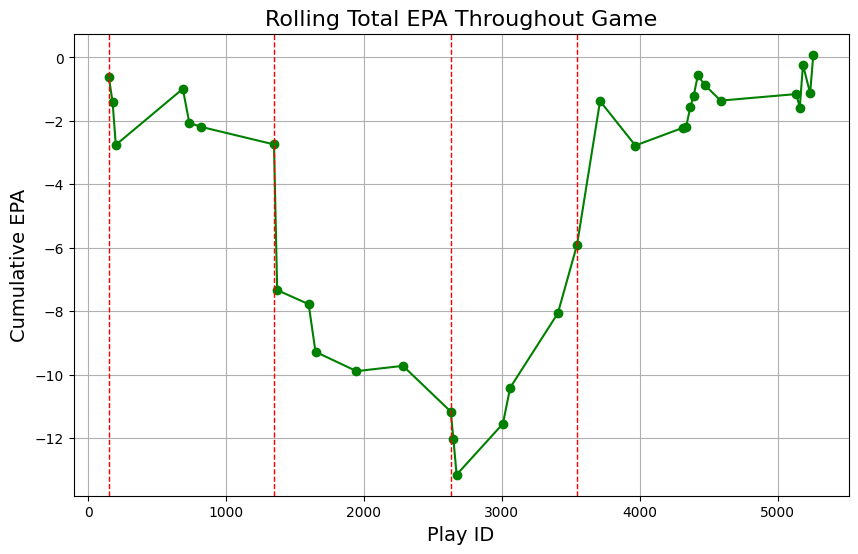

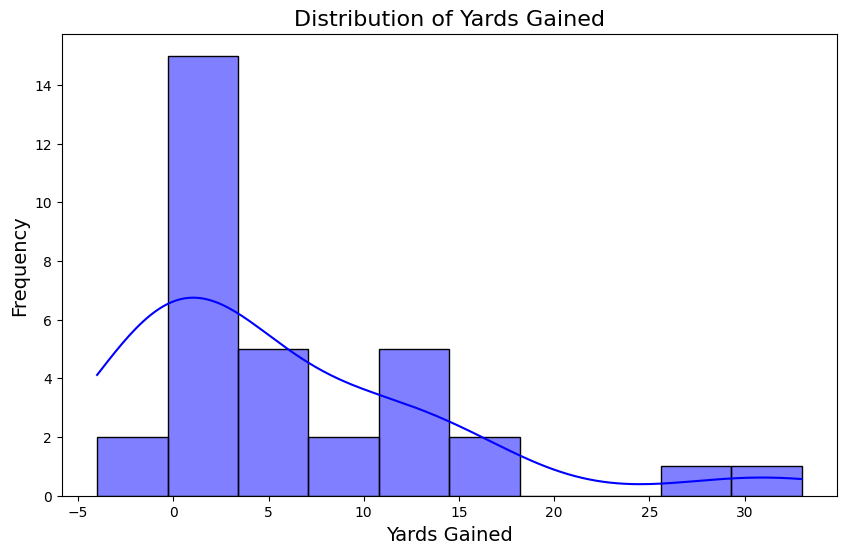

/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1297942426.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['x'] = game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1297942426.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data['y'] = game_data['air_yards']


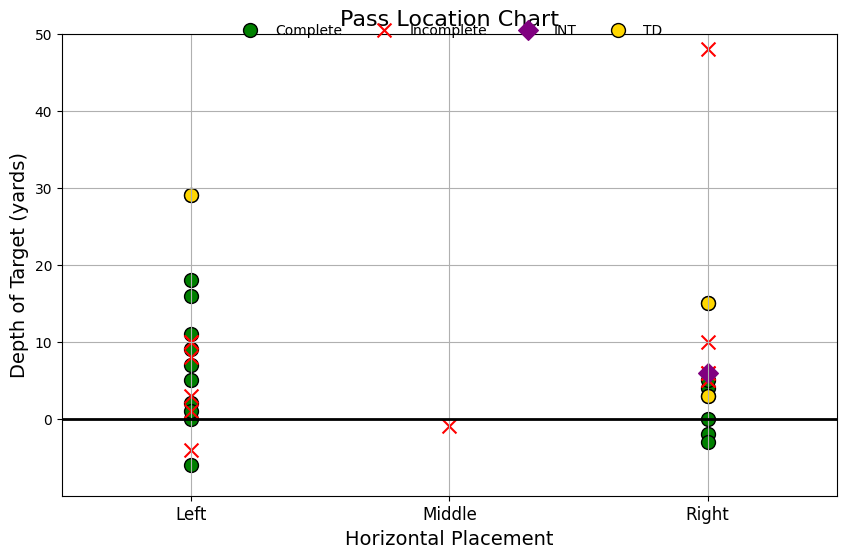

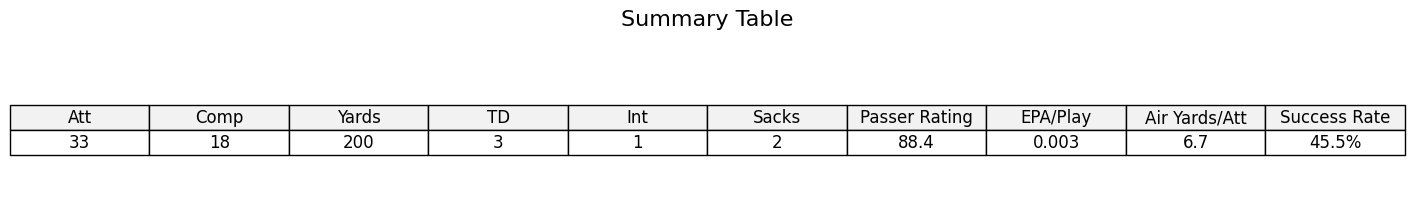

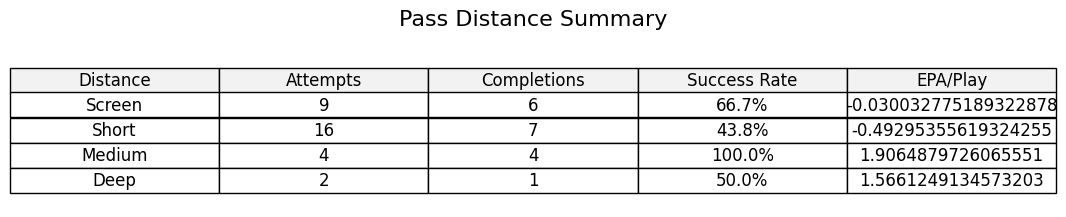

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]
filtered_hurts = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data = filtered_hurts[filtered_hurts['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts
game_data['cumulative_completions'] = game_data['complete_pass'].cumsum()
game_data['cumulative_attempts'] = game_data['pass_attempt'].cumsum()
game_data['cumulative_completion_percentage'] = (game_data['cumulative_completions'] / game_data['cumulative_attempts']) * 100

# Additional metrics calculations
game_data['epa_per_play'] = game_data['epa']
epa_per_play = round(game_data['epa_per_play'].mean(), 3)  # Show 3 decimal places

air_yards_per_attempt = round(game_data['air_yards'].sum() / game_data['pass_attempt'].sum(), 2)
success_rate = round(game_data[game_data['epa'] > 0].shape[0] / game_data.shape[0] * 100, 1)

# Calculate passer rating
completions = game_data['complete_pass'].sum()
attempts = game_data['pass_attempt'].sum()
yards = game_data['passing_yards'].sum()
touchdowns = game_data['pass_touchdown'].sum()
interceptions = game_data['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Calculate rolling total EPA
game_data['rolling_total_epa'] = game_data['epa'].cumsum()

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = game_data[game_data['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data['pass_distance_category'] = pd.cut(game_data['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'mean'
}).reset_index()

pass_distance_summary['Success Rate'] = (pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']) * 100
pass_distance_summary['EPA/Play'] = pass_distance_summary['epa']
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]
pass_distance_summary.columns = ['Distance', 'Attempts', 'Completions', 'Success Rate', 'EPA/Play']

# Format numbers without decimal points in the tables
pass_distance_summary['Attempts'] = pass_distance_summary['Attempts'].astype(int)
pass_distance_summary['Completions'] = pass_distance_summary['Completions'].astype(int)
pass_distance_summary['Success Rate'] = pass_distance_summary['Success Rate'].apply(lambda x: f"{x:.1f}%")

# Summary Table
summary_table = {
    'Att': [int(game_data['pass_attempt'].sum())],
    'Comp': [int(game_data['complete_pass'].sum())],
    'Yards': [int(game_data['passing_yards'].sum())],
    'TD': [int(game_data['pass_touchdown'].sum())],
    'Int': [int(game_data['interception'].sum())],
    'Sacks': [int(game_data['sack'].sum())],
    'Passer Rating': [passer_rating],
    'EPA/Play': [epa_per_play],
    'Air Yards/Att': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}
summary_df = pd.DataFrame.from_dict(summary_table)


# Function to plot Rolling Total EPA
def plot_rolling_epa(game_data: pd.DataFrame, quarter_positions: list):
    plt.figure(figsize=(10, 6))
    plt.plot(game_data['play_id'], game_data['rolling_total_epa'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Play ID', fontsize=14)
    plt.ylabel('Cumulative EPA', fontsize=14)
    plt.title('Rolling Total EPA Throughout Game', fontsize=16)
    plt.grid(True)
    plt.show()


# Function to plot Distribution of Yards Gained
def plot_yards_distribution(game_data: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    sns.histplot(game_data['yards_gained'], bins=10, kde=True, color='blue')
    plt.xlabel('Yards Gained', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Yards Gained', fontsize=16)
    plt.show()


# Function to plot Passing Chart
def plot_passing_chart(game_data: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    game_data['x'] = game_data['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
    game_data['y'] = game_data['air_yards']

    complete = game_data[game_data['complete_pass'] == 1]
    incomplete = game_data[game_data['complete_pass'] == 0]
    interceptions = game_data[game_data['interception'] == 1]
    touchdowns = game_data[game_data['pass_touchdown'] == 1]

    plt.scatter(complete['x'], complete['y'], color='green', label='Complete', s=100, edgecolor='black')
    plt.scatter(incomplete['x'], incomplete['y'], color='red', marker='x', label='Incomplete', s=100)
    plt.scatter(interceptions['x'], interceptions['y'], color='purple', marker='D', label='INT', s=100)
    plt.scatter(touchdowns['x'], touchdowns['y'], color='gold', marker='o', label='TD', s=100, edgecolor='black')

    plt.axhline(0, color='black', linewidth=2)  # Line of scrimmage
    plt.xlim(-1.5, 1.5)
    plt.ylim(-10, 50)
    plt.xticks([-1, 0, 1], ['Left', 'Middle', 'Right'], fontsize=12)
    plt.yticks(range(0, 51, 10))
    plt.xlabel('Horizontal Placement', fontsize=14)
    plt.ylabel('Depth of Target (yards)', fontsize=14)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=10, frameon=False)
    plt.title('Pass Location Chart', fontsize=16)
    plt.grid(True)
    plt.show()


# Function to display Summary Table
def display_summary_table(summary_df: pd.DataFrame):
    plt.figure(figsize=(10, 2))
    plt.axis('off')
    table = plt.table(cellText=summary_df.values,
                      colLabels=summary_df.columns,
                      cellLoc='center',
                      loc='center',
                      colColours=['#f2f2f2'] * len(summary_df.columns),
                      colWidths=[0.12] * len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    plt.title('Summary Table', fontsize=16, pad=20)
    plt.show()


# Function to display Pass Distance Table
def display_pass_distance_table(pass_distance_summary: pd.DataFrame):
    plt.figure(figsize=(10, 2))
    plt.axis('off')
    table = plt.table(cellText=pass_distance_summary.values,
                      colLabels=pass_distance_summary.columns,
                      cellLoc='center',
                      loc='center',
                      colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
                      colWidths=[0.18] * len(pass_distance_summary.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    plt.title('Pass Distance Summary', fontsize=16, pad=20)
    plt.show()


# Call the individual plotting functions
plot_rolling_epa(game_data, quarter_positions)
plot_yards_distribution(game_data)
plot_passing_chart(game_data)
display_summary_table(summary_df)
display_pass_distance_table(pass_distance_summary)


/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1398677871.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data_passing['cumulative_completions'] = game_data_passing['complete_pass'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1398677871.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_data_passing['cumulative_attempts'] = game_data_passing['pass_attempt'].cumsum()
/var/folders/5f/tx_7z3s176g8sns4d9yvw09h0000gn/T/ipykernel_4066/1398677871.py:31

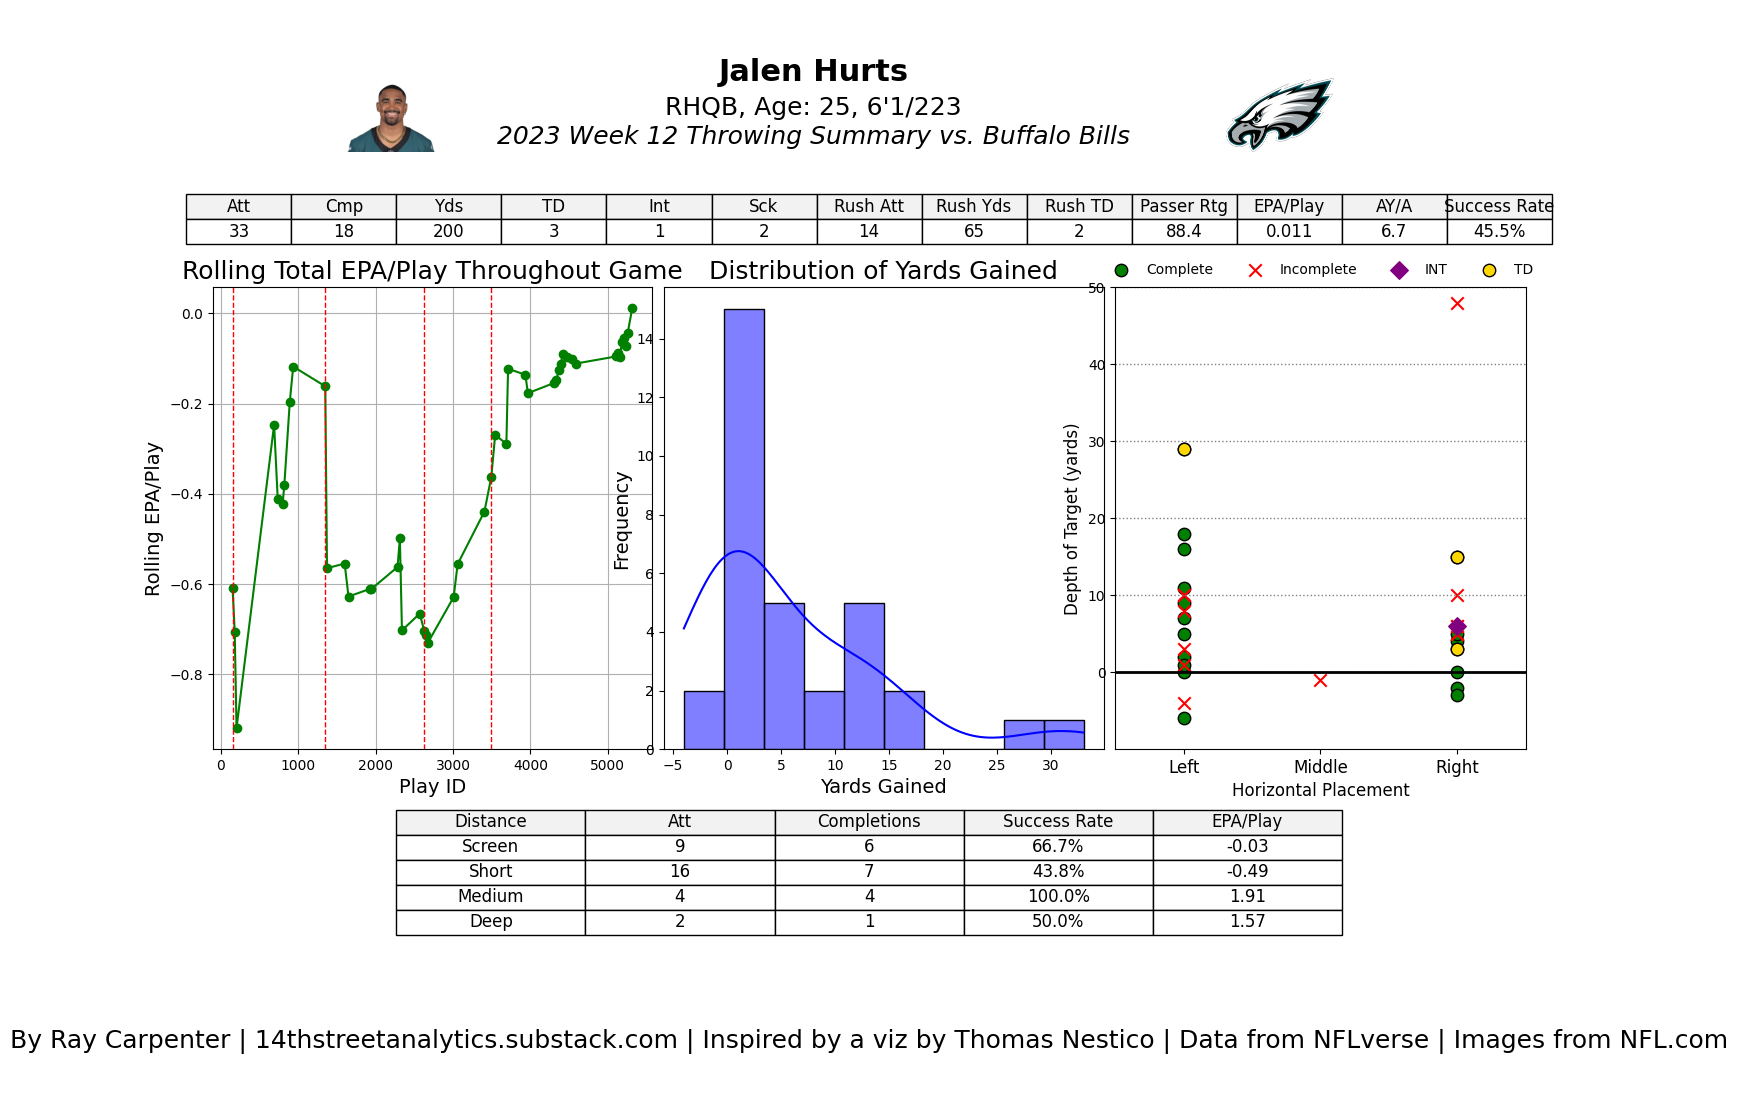

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

# Define the year and load the data
YEAR = 2023
url = f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{YEAR}.csv.gz'
data = pd.read_csv(url, compression='gzip', low_memory=False)

# Set options for displaying dataframes
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 400)

# Filter by team (Philadelphia Eagles) and quarterback Jalen Hurts
filtered_df = data[(data['home_team'] == 'PHI') | (data['away_team'] == 'PHI')]

# Separate filters for passing and rushing plays
passing_plays = filtered_df[filtered_df['passer_player_name'] == 'J.Hurts']
rushing_plays = filtered_df[filtered_df['rusher_player_name'] == 'J.Hurts']

# Filter data for a specific game (e.g., 2023_12_BUF_PHI)
game_data_passing = passing_plays[passing_plays['game_id'] == '2023_12_BUF_PHI']
game_data_rushing = rushing_plays[rushing_plays['game_id'] == '2023_12_BUF_PHI']

# Calculate cumulative completions and attempts for passing plays
game_data_passing['cumulative_completions'] = game_data_passing['complete_pass'].cumsum()
game_data_passing['cumulative_attempts'] = game_data_passing['pass_attempt'].cumsum()
game_data_passing['cumulative_completion_percentage'] = (
    game_data_passing['cumulative_completions'] / game_data_passing['cumulative_attempts']
) * 100

# Sum EPA for both passing and rushing plays
total_passing_epa = game_data_passing['epa'].sum()
total_rushing_epa = game_data_rushing['epa'].sum()
total_epa = total_passing_epa + total_rushing_epa

# Sum the total number of plays (passing attempts + rushing attempts)
total_plays = game_data_passing['pass_attempt'].sum() + game_data_rushing['rush_attempt'].sum()

# Calculate EPA per play
epa_per_play = round(total_epa / total_plays, 3)

air_yards_per_attempt = round(
    game_data_passing['air_yards'].sum() / game_data_passing['pass_attempt'].sum(), 2
)
success_rate = round(
    game_data_passing[game_data_passing['epa'] > 0].shape[0] / game_data_passing.shape[0] * 100, 1
)

# Calculate passer rating
completions = game_data_passing['complete_pass'].sum()
attempts = game_data_passing['pass_attempt'].sum()
yards = game_data_passing['passing_yards'].sum()
touchdowns = game_data_passing['pass_touchdown'].sum()
interceptions = game_data_passing['interception'].sum()

if attempts > 0:
    comp_pct = completions / attempts
    avg_yards = yards / attempts
    td_pct = touchdowns / attempts
    int_pct = interceptions / attempts

    passer_rating = (comp_pct * 5 + avg_yards * 0.25 + td_pct * 20 - int_pct * 25) / 6 * 100
    passer_rating = round(passer_rating, 1)
else:
    passer_rating = 0

# Include 'game_seconds_remaining' when combining passing and rushing plays
combined_plays = pd.concat([
    game_data_passing[['play_id', 'epa', 'game_seconds_remaining']],
    game_data_rushing[['play_id', 'epa', 'game_seconds_remaining']]
])
combined_plays.sort_values('play_id', inplace=True)
combined_plays['rolling_total_epa'] = combined_plays['epa'].cumsum()
combined_plays['rolling_play_count'] = range(1, len(combined_plays) + 1)
combined_plays['rolling_epa_per_play'] = combined_plays['rolling_total_epa'] / combined_plays['rolling_play_count']

# Determine play IDs for quarter lines using game_seconds_remaining
quarter_end_times = [3600, 2700, 1800, 900, 0]  # End times for Q1, Q2, Q3, Q4, OT (seconds)
quarter_positions = []

for end_time in quarter_end_times:
    try:
        play_id = combined_plays[combined_plays['game_seconds_remaining'] <= end_time].iloc[0]['play_id']
        quarter_positions.append(play_id)
    except IndexError:
        continue

# Create bins for pass distances
bins = [-np.inf, 1, 10, 25, np.inf]
labels = ['Screen', 'Short', 'Medium', 'Deep']
game_data_passing['pass_distance_category'] = pd.cut(game_data_passing['air_yards'], bins=bins, labels=labels)

# Calculate success rate, EPA/play, attempts, and completions for each category
pass_distance_summary = game_data_passing.groupby('pass_distance_category').agg({
    'pass_attempt': 'sum',
    'complete_pass': 'sum',
    'epa': 'sum'  # Sum EPA for each category
}).reset_index()

# Calculate EPA per play for each category by dividing total EPA by total pass attempts
pass_distance_summary['EPA/Play'] = (pass_distance_summary['epa'] / pass_distance_summary['pass_attempt']).round(2)

pass_distance_summary['Success Rate'] = (pass_distance_summary['complete_pass'] / pass_distance_summary['pass_attempt']) * 100
pass_distance_summary = pass_distance_summary[['pass_distance_category', 'pass_attempt', 'complete_pass', 'Success Rate', 'EPA/Play']]

# Update the column names, including changing "Attempts" to "Att"
pass_distance_summary.columns = ['Distance', 'Att', 'Completions', 'Success Rate', 'EPA/Play']

# Format numbers without decimal points in the tables
pass_distance_summary['Att'] = pass_distance_summary['Att'].astype(int)
pass_distance_summary['Completions'] = pass_distance_summary['Completions'].astype(int)
pass_distance_summary['Success Rate'] = pass_distance_summary['Success Rate'].apply(lambda x: f"{x:.1f}%")

# Calculate rushing statistics for Jalen Hurts
rush_attempts = game_data_rushing['rush_attempt'].sum()
rush_yards = game_data_rushing['rushing_yards'].sum()
rush_touchdowns = game_data_rushing['rush_touchdown'].sum()

# Update the summary table with passing and rushing stats
summary_table = {
    'Att': [int(game_data_passing['pass_attempt'].sum())],
    'Cmp': [int(game_data_passing['complete_pass'].sum())],
    'Yds': [int(game_data_passing['passing_yards'].sum())],
    'TD': [int(game_data_passing['pass_touchdown'].sum())],
    'Int': [int(game_data_passing['interception'].sum())],
    'Sck': [int(game_data_passing['sack'].sum())],
    'Rush Att': [int(rush_attempts)],        # Added Rush Att
    'Rush Yds': [int(rush_yards)],           # Added Rush Yds
    'Rush TD': [int(rush_touchdowns)],       # Added Rush TD
    'Passer Rtg': [passer_rating],
    'EPA/Play': [epa_per_play],              # Corrected EPA/Play
    'AY/A': [air_yards_per_attempt],
    'Success Rate': [f"{success_rate}%"]
}

# Create the updated summary DataFrame
summary_df = pd.DataFrame.from_dict(summary_table)

# Load images
headshot_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/hurts_headshot.png'
logo_path = '/Users/raymondcarpenter/Documents/GitHub/14thstreetanalytics/throwing_summary/philadelphia-eagles-logo.png'
headshot = Image.open(headshot_path)
logo = Image.open(logo_path)

def jalen_hurts_dashboard(game_data_passing: pd.DataFrame, headshot: Image, logo: Image, summary_df: pd.DataFrame, pass_distance_summary: pd.DataFrame, quarter_positions):
    # Create a more compact figure
    fig = plt.figure(figsize=(18, 14))  # Adjust figure size for compactness

    # Create a gridspec layout with adjusted settings for alignment and spacing
    gs = gridspec.GridSpec(6, 20,  # Using 20 columns for better spacing
                           height_ratios=[2, 4, 4, 25, 10, 5],  # Adjusted height ratio for row 4 and others
                           width_ratios=[1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 4, 1, 3, 1, 3, 1, 3, 1, 1])  # Equal width for plots and tables

    # Define the positions of each subplot in the grid
    ax_headshot = fig.add_subplot(gs[1, 2:4])  # Positioned headshot
    ax_bio = fig.add_subplot(gs[1, 5:13])  # Centered bio text more
    ax_logo = fig.add_subplot(gs[1, 14:16])  # Positioned logo

    ax_summary_table = fig.add_subplot(gs[2, 1:19])

    # Adjust plot positions for compactness
    ax_rolling_epa = fig.add_subplot(gs[3, 1:7])  # Rolling EPA
    ax_yards_dist = fig.add_subplot(gs[3, 7:13])  # Yards Distribution
    ax_passing_chart = fig.add_subplot(gs[3, 13:19])  # Pass Location Chart

    ax_pass_distance = fig.add_subplot(gs[4, 1:19])  # Pass Distance Table

    ax_footer = fig.add_subplot(gs[-1, 1:19])  # Footer
    ax_left = fig.add_subplot(gs[:, 0])
    ax_right = fig.add_subplot(gs[:, -1])

    # Hide axes for footer, left, and right
    ax_footer.axis('off')
    ax_left.axis('off')
    ax_right.axis('off')

    # Plot headshot and logo correctly
    ax_headshot.imshow(headshot)
    ax_headshot.axis('off')
    ax_logo.imshow(logo)
    ax_logo.axis('off')

    # Biographical Information with adjusted horizontal and vertical space
    ax_bio.text(0.5, 0.95, 'Jalen Hurts', fontsize=22, ha='center', fontweight='bold')  # Centered and adjusted
    ax_bio.text(0.5, 0.50, 'RHQB, Age: 25, 6\'1/223', fontsize=18, ha='center')  # Adjusted vertical spacing
    ax_bio.text(0.5, 0.1, '2023 Week 12 Throwing Summary vs. Buffalo Bills', fontsize=18, ha='center', fontstyle='italic')  # Adjusted vertical spacing
    ax_bio.axis('off')

    # Summary Table Plot - Adjusted for more compact cells
    ax_summary_table.axis('off')
    table = ax_summary_table.table(cellText=summary_df.values,
                                   colLabels=summary_df.columns,
                                   cellLoc='center',
                                   loc='center',
                                   colColours=['#f2f2f2'] * len(summary_df.columns),
                                   colWidths=[0.1] * len(summary_df.columns))  # Reduced column width
    table.auto_set_font_size(False)
    table.set_fontsize(12)  # Set a smaller font size for compactness
    table.scale(0.8, 1.5)  # Reduced scale for compactness

    # Rolling Total EPA/Play Plot
    ax_rolling_epa.plot(combined_plays['play_id'], combined_plays['rolling_epa_per_play'], marker='o', linestyle='-', color='green')
    for pos in quarter_positions:
        ax_rolling_epa.axvline(x=pos, color='red', linestyle='--', linewidth=1)
    ax_rolling_epa.set_xlabel('Play ID', fontdict={'size': 14})
    ax_rolling_epa.set_ylabel('Rolling EPA/Play', fontdict={'size': 14})
    ax_rolling_epa.set_title('Rolling Total EPA/Play Throughout Game', fontdict={'size': 18})
    ax_rolling_epa.grid(True)

    # Yards Gained Distribution Plot
    sns.histplot(game_data_passing['yards_gained'], bins=10, kde=True, color='blue', ax=ax_yards_dist)
    ax_yards_dist.set_xlabel('Yards Gained', fontdict={'size': 14})
    ax_yards_dist.set_ylabel('Frequency', fontdict={'size': 14})
    ax_yards_dist.set_title('Distribution of Yards Gained', fontdict={'size': 18})

    # Pass Location Chart Plot
    game_data_passing['x'] = game_data_passing['pass_location'].replace({'left': -1, 'middle': 0, 'right': 1})
    game_data_passing['y'] = game_data_passing['air_yards']

    complete = game_data_passing[game_data_passing['complete_pass'] == 1]
    incomplete = game_data_passing[game_data_passing['complete_pass'] == 0]
    interceptions = game_data_passing[game_data_passing['interception'] == 1]
    touchdowns = game_data_passing[game_data_passing['pass_touchdown'] == 1]

    ax_passing_chart.scatter(complete['x'], complete['y'], color='green', label='Complete', s=80, edgecolor='black')
    ax_passing_chart.scatter(incomplete['x'], incomplete['y'], color='red', marker='x', label='Incomplete', s=80)
    ax_passing_chart.scatter(interceptions['x'], interceptions['y'], color='purple', marker='D', label='INT', s=80)
    ax_passing_chart.scatter(touchdowns['x'], touchdowns['y'], color='gold', marker='o', label='TD', s=80, edgecolor='black')

    # Add horizontal dotted lines every 10 yards
    for y in range(0, 51, 10):
        ax_passing_chart.axhline(y, color='gray', linestyle=':', linewidth=1)

    # Formatting
    ax_passing_chart.axhline(0, color='black', linewidth=2)  # Line of scrimmage
    ax_passing_chart.set_xlim(-1.5, 1.5)
    ax_passing_chart.set_ylim(-10, 50)
    ax_passing_chart.set_xticks([-1, 0, 1])
    ax_passing_chart.set_xticklabels(['Left', 'Middle', 'Right'], fontsize=12)
    ax_passing_chart.set_yticks(range(0, 51, 10))
    ax_passing_chart.set_xlabel('Horizontal Placement', fontsize=12)
    ax_passing_chart.set_ylabel('Depth of Target (yards)', fontsize=12)

    # Set legend as the title, placed on top
    ax_passing_chart.legend(loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=4, fontsize=10, frameon=False)

    # Pass Distance Table
# Pass Distance Table
    ax_pass_distance.axis('off')
    pass_distance_table = ax_pass_distance.table(
        cellText=pass_distance_summary.values,
        colLabels=pass_distance_summary.columns,
        cellLoc='center',
        loc='center',
        colColours=['#f2f2f2'] * len(pass_distance_summary.columns),
        colWidths=[0.18] * len(pass_distance_summary.columns)  # Column width adjustment
    )
    pass_distance_table.auto_set_font_size(False)
    pass_distance_table.set_fontsize(12)  # Font size adjustment
    pass_distance_table.scale(.8, 1.5)  # Scaling adjustment


    # Footer
    ax_footer.text(0.5, 0.5, 'By Ray Carpenter | 14thstreetanalytics.substack.com | Inspired by a viz by Thomas Nestico | Data from NFLverse | Images from NFL.com', 
                   ha='center', va='center', fontsize=18)

    # Adjust the spacing between subplots with increased padding
    plt.tight_layout(pad=1.5)  # Reduced padding for less whitespace

    # Show the figure
    plt.show()

# Call the modified dashboard function
jalen_hurts_dashboard(game_data_passing, headshot, logo, summary_df, pass_distance_summary, quarter_positions)
